COMPUTER PROGRAMMING PROJECT

First, I generated the data using my ID (3224274) as a seed. Then, i respresented the landscape in 3d to better understand the problem.

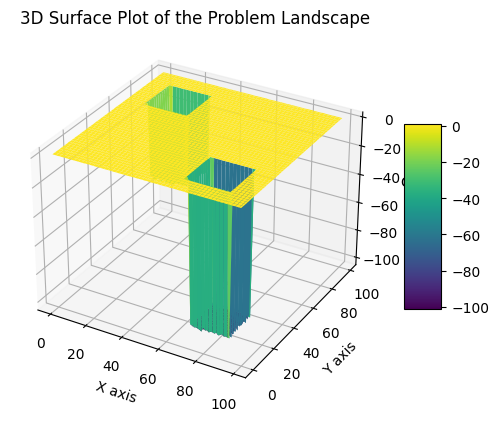

In [189]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from copy import deepcopy
import time


def generate_data(n, seed):
    if type(seed) != str:
        raise TypeError("The seed should be the string representing your ID")
    if type(n) != int:
        raise TypeError("The dimension of the problem should be an integer value")
    if n%2 != 0:
        raise ValueError("The dimension of the problem should be even!!")
    
    aggregate_counter = 0
    for char in seed:
        aggregate_counter += int(char)
    
    aggregate_counter = 10*aggregate_counter
    marginal_diff = int(aggregate_counter)%n 
    bsize = 12 + int(np.floor(n**(1/2)))
    if (bsize%2)!=0:
        bsize=bsize-1
    
    if (marginal_diff<bsize+4):
        marginal_diff = bsize+4  
    if (marginal_diff > (n-bsize-4)):
        marginal_diff = n-bsize-4
    if ((marginal_diff > n/2 - bsize-5) and (marginal_diff < n/2+bsize+5)):
        marginal_diff = int(n/2-bsize-5)
    
    c_marginal_diff = n-marginal_diff
    
    b1 = -100 + np.random.randn(bsize, bsize)
    b2 = -50 + np.random.randn(bsize, bsize)
    

    f_values = np.zeros((n,n), dtype=np.float32)
    f_values = 1+ 0.05*np.random.randn(n,n)
    f_values[marginal_diff-bsize//2:marginal_diff+bsize//2, c_marginal_diff-bsize//2:c_marginal_diff+bsize//2] = b1
    f_values[c_marginal_diff-bsize//2:c_marginal_diff+bsize//2, marginal_diff-bsize//2:marginal_diff+bsize//2] = b2
    return f_values


f_values = generate_data(100, '3224274')

n = f_values.shape[0]
x = np.arange(n)
y = np.arange(n)
X, Y = np.meshgrid(x, y)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, f_values, cmap='viridis', edgecolor='none')

ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Cost')
ax.set_title('3D Surface Plot of the Problem Landscape')

fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()


TASK 1: I implemented the class for the problem, defined in a (nxn) space. The problem is initialized at a random state (i,j) representing a point in the grid. The move proposal is designed to propose a movement of step 1 along 4 directions (up-down-left-right), even allowing border jumping if needed (modulo n operation).
When trying to scale the size of the problem (increasing n, as shown later), I noticed the algorithm struggled to explore the solution space in reasonable time given the standard move proposal (propose_move_standard, one step in the four directions), so also I tried out a different move proposal: propose_move_adaptive, which randomly picks a step everytime it proposes a new move. The purpose of the introduction of an alternative move is to further analyze the problem landscape and to have a comparison term for our standard move.
I constructed the alternative move to have different useful properties: - no diagoal terms (the proposed step is strictly greater than one); -connectedness (being randomized, it is possible to get to any configuration from any other, given enough steps, with non-zero probability); aperiodicity (the move is pseudorandom); symmetry (there is the same probability of proposing a move from i -> j than j -> i).
Furthermore, the compute_delta_cost method has been optimized to reduce the number of operations needed to compute the difference between the new and old cost (without creating a copy of the problem).
After implementing the ‘Probl’ class, I pasted the simulated annealing function we used during class, adopting some changes:
-	Implemented a Convergence Timer and Flag (a Boolean value initialized at False), so that, if the Optimization found the desired value (or range, as we will see), the Convergence Timer stops and the Flag turns into True, indicating that the attempt was successful. ( Note that it could've been inserted a break after convergence but I wanted to gather data about the whole process even after convergence for successive tasks)
-	Initialized two lists, ‘min_seq’ and ‘acc_rate_seq’, to record the data about the minimum value and acceptance rates found for each annealing step
-	Inserted an ‘if statement’ at the beginning of each ‘Mcmc step’ to be able to chose which move to perform at each iteration
-	Returned 5 information: • convergence time; • best cost; • min_seq (a list containing the values of the minimum value found at each annealing step); • success (Boolean variable indicating whether the optimization was successful; • beta list (not quite necessary, but useful when plotting and experimenting).
Then, I implemented the ‘accept’ function, returning True or False based on the Metropolis acceptance rule (more on that later in the analysis).
Lastly, I also inserted the ‘greedy’ optimization algorithm for comparison purposes.


In [190]:
class Probl:
    def __init__(self, table):
        self.table = table
        self.n = self.table.shape[0]
        self.i = 0
        self.j = 0

        #initialize a set of all visited points
        self.visited = set()
        
        self.init_config()
        
    def init_config(self):
        self.i = np.random.randint(0,self.n)
        self.j = np.random.randint(0,self.n)
        self.initial_state = self.i, self.j

        # add the initial state to the set of visited points
        self.visited.add(self.initial_state)
        
    def plot_state(self):
        plt.imshow(self.table, cmap='viridis')
        plt.colorbar()

        #plot the visited points in red
        for (i, j) in self.visited:
            plt.plot(j, i, 'o', color='red')
        plt.plot(self.j, self.i, 'o', color='black')  # Plot current position in black
        plt.show()  # Pause to display the plot; adjust as needed
    
    def propose_move_standard(self):
        n = self.n
        
        i = np.random.choice([self.i-1, self.i+1]) % n
        j = np.random.choice([self.j-1, self.j+1]) % n
        return i, j
    
    def propose_move_adaptive(self):
        n = self.n
        step = np.random.randint(1,n)
        i = np.random.choice([self.i-step, self.i+step]) % n
        j = np.random.choice([self.j-step, self.j+step]) % n
        return i, j
    
        
    def accept_move(self, move):
        i,j = move
        self.i = i
        self.j = j
        self.visited.add((i,j))
        
    def cost(self):
        return self.table[self.i, self.j]
    
    def compute_delta_cost(self, move):
        c1 = self.table[move]
        c0 = self.table[self.i, self.j]
        return c1-c0
    
    def copy(self):
        g = Probl(self.table)
        g.i = self.i
        g.j = self.j

In [191]:
def accept(delta_c, beta):
    if delta_c <= 0:
        return True
    ## If the cost increases and beta is infinite, we always reject
    if beta == np.inf:
        return False
    ## Otherwise the probability is going to be somwhere between 0 and 1
    p = np.exp(-beta * delta_c)
    ## Returns True with probability p
    return np.random.random() < p

def simann(n, ID, data = None, anneal_steps = 100, mcmc_steps = 200, beta0 = 0.0001, 
           beta1 = 10.0, seed = None, standard = False, adaptive = False, convergence = True, plotting = False):
    
    # Convergence timer and flag
    t1 = time.time()
    t_final = 0
    flag = False

    # To be able to replicate trials
    if seed is not None:
        np.random.seed(seed)

    # If data is not provided, the function proceeds to generate it
    if data is None:
        data = generate_data(n, ID)

    # Creates an instance of the problem
    probl = Probl(data)

    # Creates the annealing schedule, ending at beta = np.inf ( basically greedy at last iteration)
    beta_list = np.zeros(anneal_steps)

    beta_list[:-1] = np.linspace(beta0, beta1, anneal_steps - 1)

    beta_list[-1] = np.inf

    # Set up the initial configuration, compute and (optional) print the initial cost
    probl.init_config()
    c = probl.cost()
    #print(f"initial cost = {c}")
    
    # Initialized the Sucess Flag to false
    success = False

    # Computed the actual minimum thanks to numpy optimisation
    actual_minimum = np.min(probl.table)
    

    ## Keep the best cost seen so far, and its associated configuration.
    best = probl.copy()
    best_c = c

    #List containing the best cost found for every annealing step (changing beta)
    min_seq = np.zeros(anneal_steps, dtype = float)

    # List containing the acceptance rate recorded at every annealing step
    acc_rate_seq = np.zeros(anneal_steps, dtype = float)

    # For every temperature
    for k, beta in enumerate(beta_list):

        ## Acceptded moves counter
        accepted = 0

        # For each beta, perform a number of MCMC steps
        for t in range(mcmc_steps):
            if standard:
                move = probl.propose_move_standard()
            elif adaptive:
                move = probl.propose_move_adaptive()
            delta_c = probl.compute_delta_cost(move)

            ## Metropolis rule
            if accept(delta_c, beta):
                
                #if the move is accepted, update the problem and the cost
                probl.accept_move(move)
                c += delta_c

                # increase accepted moves counter
                accepted += 1
                
                # if this is the best instance of the problem (best_cost), update both best problem and best cost
                if c <= best_c:
                    best_c = c
                    best = probl.copy()
                    #plt.clf()

                    # optional, plot the problem every time a better value is found
                    #probl.plot_state()
    
        #print(f"••••acc.rate={accepted/mcmc_steps} beta={beta} c={c} [best={best_c}]", '\n')
        
        #append the acceptance rate relative to the specific beta
        acc_rate = accepted / mcmc_steps

        acc_rate_seq[k] = acc_rate

        # append the best value found at the give temperature
        min_seq[k]= (best_c)

        # if the flag is still inactive, check for the convergence condition
        if convergence and not flag:
            if np.abs(best_c-actual_minimum) < 3:
                success = True
                t_final = t_final = time.time()-t1
                flag = True
                #print('converged in time', t_final)
                #print('Close to minimum')
                #break (optional)
        
            
    # if the flag is still down at the end of all iterations, the optimisation is unsuccessfull and the final time is returned   
    if not flag:
        t_final = t_final = time.time()-t1
    
    # if we want to plot the final configuration
    if plotting:
        probl.plot_state()
        # if we also want to plot the visited nodes during the optimization
   
            

    ## Return the best instance
    #print(f"final cost = {best_c}")
    #print('actual minimum', actual_minimum)
    #print('final time', t_final)
    
    return t_final, best_c, min_seq, success, acc_rate_seq, beta_list




def greedy(probl, repeats=100, num_iters=10, seed=None):
    if seed is not None:
        np.random.seed(seed)
    
    # Best cost initialized at np.inf
    best_c = np.inf

    # initial best instance of the problem
    best_probl = probl
    
    # initialize the problem r times
    for r in range(repeats):

        # initialize the problem in a new random state
        probl.init_config()

        #calculate the cost of current state
        cx = probl.cost()

        # probl.display()
        print(f"initial cost is c={cx}", 'r=', r)

        # proposing num_iters steps
        for t in range(num_iters):
            
            move = probl.propose_move_standard()
           
            delta_c = probl.compute_delta_cost(move)
            
            #naive greedy criterion
            if delta_c <= 0:
                # if accepted, update problem and cost
                probl.accept_move(move)
                cx += delta_c
                
        # at the end of every initialization, update the best cost 
        print(f"final cost = {cx}")
        if best_c >= cx: 
            best_c = cx
            best_probl = probl.copy()
            
    
    best_probl.plot_state()
    print(f"best cost = {best_c}")
        # stopping criterion -> maximum number of iterations reached
    return best_probl, best_c
        
simann(100, '3224274', adaptive=True, seed = 123)

#print(greedy(probl))

# table = generate_data(100, '3224274')
# plt.imshow(table[1:20, 1:20], cmap='viridis')
# plt.colorbar()

(0.00789499282836914,
 -102.7985891054607,
 array([-101.63939697, -102.25153499, -102.25153499, -102.25153499,
        -102.44307579, -102.44307579, -102.44307579, -102.44307579,
        -102.44307579, -102.44307579, -102.79858911, -102.79858911,
        -102.79858911, -102.79858911, -102.79858911, -102.79858911,
        -102.79858911, -102.79858911, -102.79858911, -102.79858911,
        -102.79858911, -102.79858911, -102.79858911, -102.79858911,
        -102.79858911, -102.79858911, -102.79858911, -102.79858911,
        -102.79858911, -102.79858911, -102.79858911, -102.79858911,
        -102.79858911, -102.79858911, -102.79858911, -102.79858911,
        -102.79858911, -102.79858911, -102.79858911, -102.79858911,
        -102.79858911, -102.79858911, -102.79858911, -102.79858911,
        -102.79858911, -102.79858911, -102.79858911, -102.79858911,
        -102.79858911, -102.79858911, -102.79858911, -102.79858911,
        -102.79858911, -102.79858911, -102.79858911, -102.79858911,
     

TASK 2:The modulo operation defined and implemented in the propose_move_standard method is convenient since it allows our optimisation algorightm to jump over borders. This property semplifies the problem as it makes the 'proposal matrix' (the moves proposed for each instance of the problem) symmetric, which allows as to use the 'simplified Metropolis Rule' for acceptance. 
Our proposal matrix (C) is a stochastic matrix, therefore all columns should sum up to 1, we always propose something according to the stated probabilities.
Therefore, if we decided not to allow the border jumping, our proposals wouldn't be symmetric, for example: if the current state (self.i,self.j) is at the right border, we would have a 1/3 probability of moving in any of the three allowed directions but, if the left (Ovest) move is accepted, there will only be a 1/4 probability of proposing the reversed move. In this case, we couldn't use the simplified acceptance rule but the more general one instead. We then would need to change both the 'propose_move' and the 'accept' function accordingly:
• propose_move would be changed from 'np.random.choice([self.i-1, self.i+1]) % n' to 'np.random.choice([max(0,self.i-1), min(self.n-1, self.i+1)])' in order to always stay within the borders of the grid.
• the ‘accept’ function would need to be changed, transitioning from the ‘simplified Metropolis rule’, to the general one that guarantees to satisfy the detailed balance condition even in non-symmetrical proposal cases (look at the word document).
To this purpsose, we would need to create a stochastic proposal matrix, with 0s in the diagonal entries, and the respective transition probabilities in the nodes (i,j) representing the probability of landing in point j coming from point i (not always symmetric)


To study the performance of the algorithm, I created an auxiliary function ‘Experiment’.
All the following experiments are designed perform 100 trials and compute the average of the results found, using 100 annealing steps, 200 ‘MCMC’ steps, and a range of problem sizes in this set: [100, 200, 500, 1000, 2000, 3500, 5000]. 
For graphical reasons, I will only include in this document the graphs related to sizes: [200,500,2000].

In [192]:
n_schedule = [100, 200, 500, 1000, 2000, 3500, 5000]

def experiment(n_schedule, anneal_steps = 100, ID = '3224274', trials = 100):

    
    # list containing the average values found for every annealing step, for every size of the problem
    values_by_n_std = np.zeros((len(n_schedule), anneal_steps))
    values_by_n_adapt = np.zeros((len(n_schedule), anneal_steps))

    # convergence time recorded based on the size of the problem
    t_by_n_std = np.zeros(len(n_schedule), dtype = float)
    t_by_n_adapt = np.zeros(len(n_schedule), dtype = float)

    # convergence rate recorded based on the size of the problem
    conv_rate_by_n_std = np.zeros(len(n_schedule), dtype = float)
    conv_rate_by_n_adapt = np.zeros(len(n_schedule), dtype = float)

    # list containing the average acceptance rates recorded for every annealing step, for every size of the problem
    acc_rate_by_n_std = np.zeros((len(n_schedule), anneal_steps))
    acc_rate_by_n_adapt = np.zeros((len(n_schedule), anneal_steps))

    # initialize a matrix to store the distribution of the best_values found for each problem size
    best_c_distribution_by_n_std = np.zeros((len(n_schedule), trials))
    best_c_distribution_by_n_adapt = np.zeros((len(n_schedule), trials))

    
    for i, n in enumerate(n_schedule):
        
        # for every size of the problem I generated the data with the same seed (my ID)
        data = generate_data(n, ID)

        # I initialized the matrix (trials x annealing steps) to record the values found at every annealing step for the 100 trails
        matrix_values_std = np.zeros((trials, anneal_steps))
        matrix_values_adapt = np.zeros((trials, anneal_steps))

        # convergence successes counter
        successes_std = 0
        successes_adapt = 0

        # total time counter (this will be divided by the trials ot obtain the average)
        t_avg_fixed_n_std = 0
        t_avg_fixed_n_adapt = 0

        # I initialized the matrix (trials x annealing steps) to record the acceptance rates found at every annealing step for the 100 trails
        matrix_accept_rate_std = np.zeros((trials, anneal_steps))
        matrix_accept_rate_adapt = np.zeros((trials, anneal_steps))

        #we initialize an array to store the distribution of best values found
        best_c_distribution_std = np.zeros(trials)
        best_c_distribution_adapt = np.zeros(trials)

        # for the 100 trials
        for t in range(trials):
            
            # record the result of the optimisation with the standard move
            t_final_std, best_c_std, matrix_values_std[t,:], converged_std, matrix_accept_rate_std[t, :], beta_list = simann(n, ID, data, standard = True, convergence=True)
            
            # if the algorithm converged we update the success counter
            if converged_std:
                successes_std += 1
            
            # record the result of the optimisation with the adaptive move
            t_final_adapt, best_c_adapt, matrix_values_adapt[t,:], converged_adapt, matrix_accept_rate_adapt[t,:], beta_list = simann(n, ID, data, adaptive = True, convergence=True)
            # if the algorithm converged we update the success counter
            if converged_adapt:
                successes_adapt += 1

            #update the total convergece time
            t_avg_fixed_n_std += t_final_std
            t_avg_fixed_n_adapt += t_final_adapt

            # for each trial record the best value found
            best_c_distribution_std[t] = best_c_std
            best_c_distribution_adapt[t] = best_c_adapt

        #store the best value found for the 100 trials for a given temperature
        best_c_distribution_by_n_std[i,:] = best_c_distribution_std
        best_c_distribution_by_n_adapt[i,:] = best_c_distribution_adapt

        # I appended the several metrics to their respective lists to store them
        t_by_n_std[i] = t_avg_fixed_n_std/trials
        t_by_n_adapt[i] = t_avg_fixed_n_adapt/trials

        conv_rate_by_n_std[i] = successes_std/trials
        conv_rate_by_n_adapt[i] = successes_adapt/trials

        # I calculated the mean of the columns of the matrix
        avg_values_std = np.mean(matrix_values_std, axis = 0)
        avg_values_adapt = np.mean(matrix_values_adapt, axis = 0)

        values_by_n_std[i, :] = (avg_values_std)
        values_by_n_adapt[i, :] = (avg_values_adapt)

        # I calculated the mean of the columns of the matrix
        avg_acc_rate_std = np.mean(matrix_accept_rate_std, axis = 0)
        avg_acc_rate_adapt = np.mean(matrix_accept_rate_adapt, axis = 0)

        acc_rate_by_n_std[i, :] = (avg_acc_rate_std)
        acc_rate_by_n_adapt[i, :] = (avg_acc_rate_adapt)

    # I packed the results for the different tasks   
    results_task3 = values_by_n_std, values_by_n_adapt, beta_list
    results_task4 = t_by_n_std, t_by_n_adapt, conv_rate_by_n_std, conv_rate_by_n_adapt
    results_task5 = acc_rate_by_n_std, acc_rate_by_n_adapt, beta_list.copy(), best_c_distribution_by_n_std, best_c_distribution_by_n_adapt
    
    return results_task3, results_task4, results_task5

results_task3, results_task4, results_task5 = experiment(n_schedule)

(100,)
(100,)
(100,)
(100,)


TASK 3: I studied the performance of the algorithm in terms of ‘Best Value’ for each step of the Annealing process. I then performed this analysis for different sizes of the problem to capture differences related to the scale.

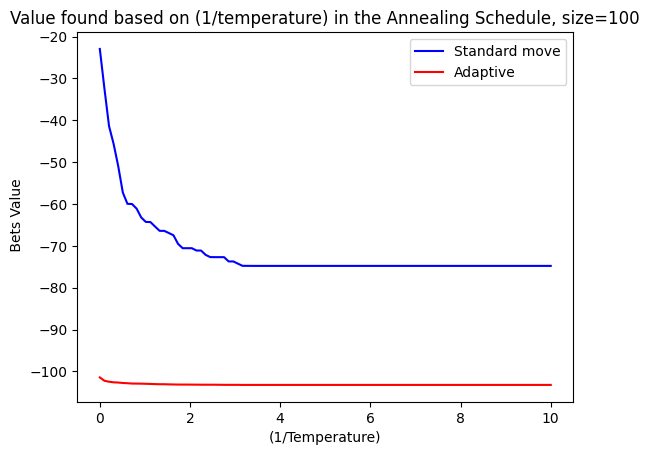

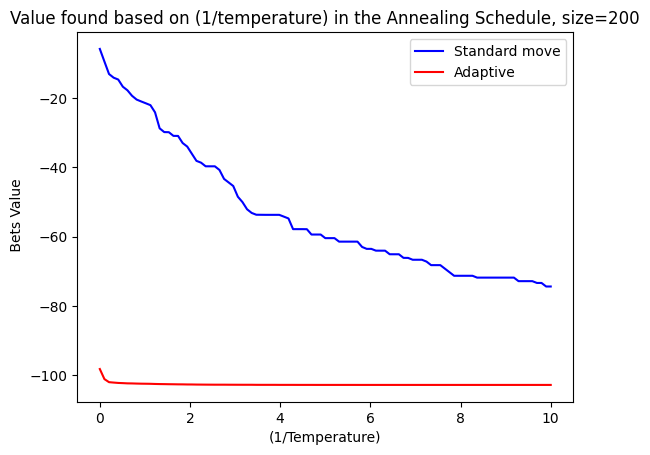

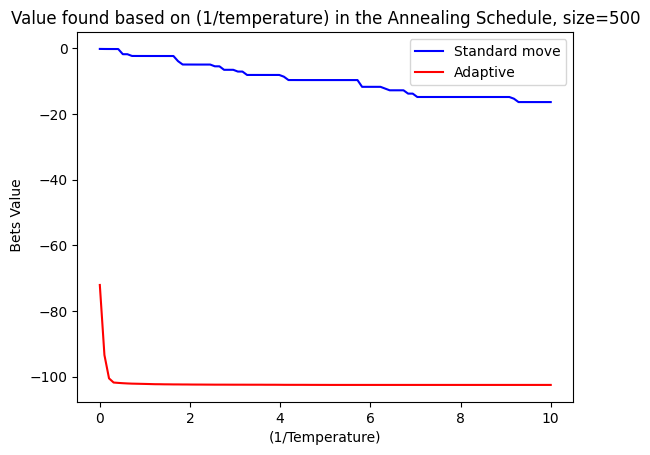

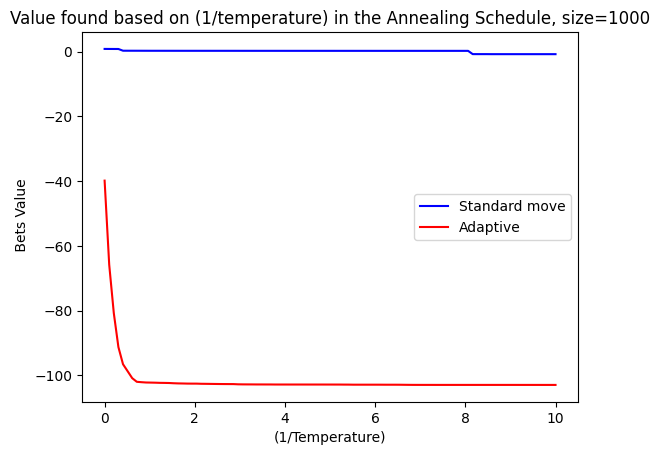

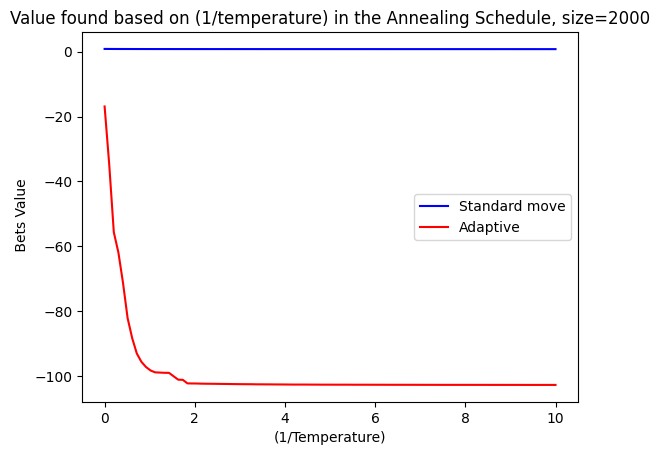

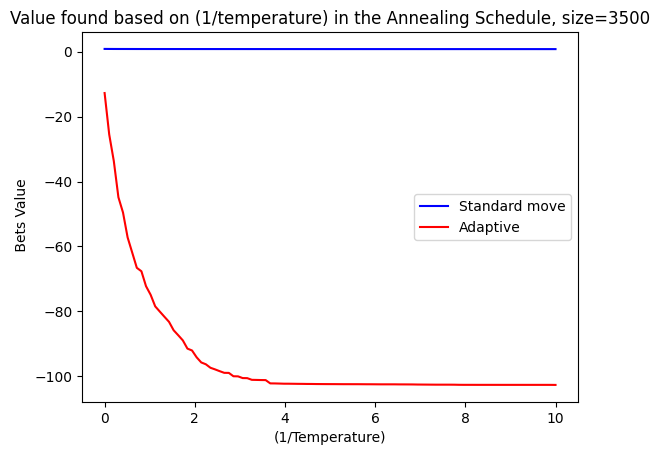

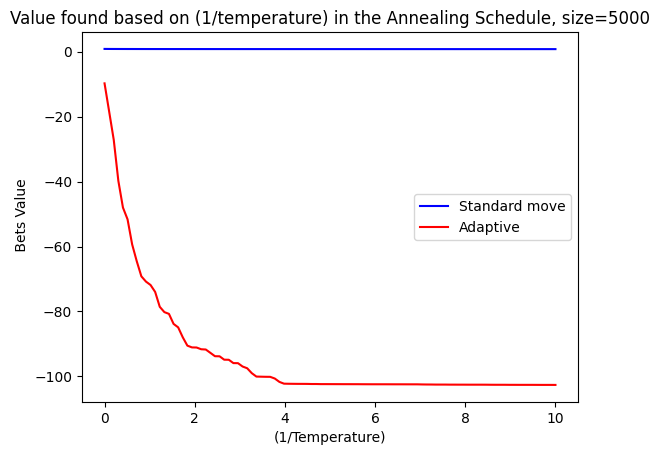

In [ ]:
def plot_task3(results_task3):
    values_by_n_std, values_by_n_adapt, beta_list = results_task3
    for i in range(len(n_schedule)):
        plt.plot(beta_list, values_by_n_std[i,:], '-', c = 'blue', label = 'Standard move')
        plt.plot(beta_list, values_by_n_adapt[i,:], '-', c = 'red', label = 'Adaptive')
        plt.xlabel('(1/Temperature)')
        plt.ylabel(' Bets Value')
        plt.title('Value found based on (1/temperature) in the Annealing Schedule, size={}'.format(n_schedule[i]))
        plt.legend()
        plt.show()

plot_task3(results_task3)

Task 3: As the graphs show, the higher the value of beta (lower temperature), the lower is the value of the best_cost found by our algorithm. Therefore, to some degree, our annealing procedure is helping us finding the minimum as allows to escape local minima by accepting moves that increase the cost with non-zero probability. Despite that, I found that our algorithm stuggles to consistently find the minimum for problems with greater sizes problems: this could be indicating that, for the given amount of (annealing*mcmc) steps, our algorithm is only able to explore a limited area of the solution space using its standard move (the length of the step is not proportional to the size of the problem, therefore the algorithm will explore a progressively lower portion of the solution space as the size of the problem increases). This could explain why yhe average value of the minimum found keeps increasing as the size of the problem increases. 
Furthermore, the adaptive move is more effective in finding the minimum as the lenght of the step is proportional to 'n', (random.randint(1,n)), performing significanly better for greater instances of the problem in terms of minimum value found. 

TASK 4: The following graphs will help to analyze the performance of the algorithm in terms of convergence speed and success. 
I noticed that the algorithm struggled to find the actual minimum (around -100 for any ‘n’), therefore, to understand whether the attempt was close to the optimal value, I considered the optimization successful if the best value found was in the neighbors of the optimal one (radius 3). 

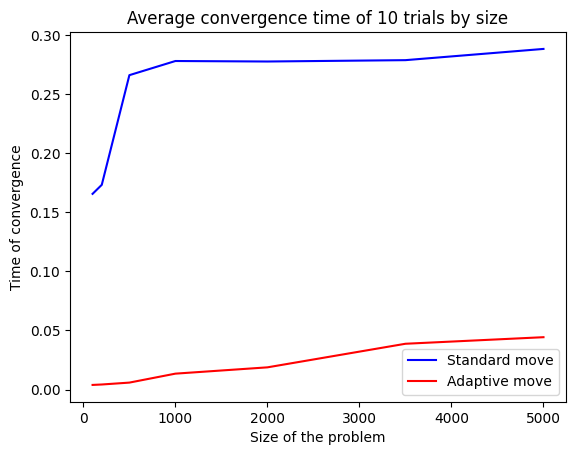

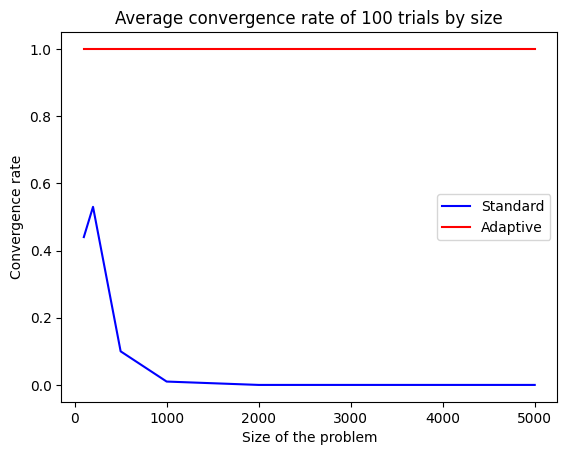

In [ ]:
def plot_task4(results_task4):
    t_by_n_std, t_by_n_adapt, conv_rate_by_n_std, conv_rate_by_n_adapt = results_task4
    #for i in range(len(n_schedule)):
    plt.plot(n_schedule, t_by_n_std, '-', c = 'blue', label = 'Standard move')
    plt.plot(n_schedule, t_by_n_adapt, '-', c = 'red', label = 'Adaptive move')
    plt.xlabel('Size of the problem')
    plt.ylabel('Time of convergence')
    plt.title('Average convergence time of 10 trials by size')
    plt.legend()
    plt.show()

    plt.plot(n_schedule, conv_rate_by_n_std, '-', c = 'blue', label = 'Standard')
    plt.plot(n_schedule, conv_rate_by_n_adapt, '-', c = 'red', label = 'Adaptive')
    plt.xlabel('Size of the problem')
    plt.ylabel('Convergence rate')
    plt.title('Average convergence rate of 100 trials by size')
    plt.legend()
    plt.show()
plot_task4(results_task4)


TASK 4: As expected, the convergence time increases with the size of the problem. 
This behavior could be due to two main reasons: 
• the increased dimensions of the grid increase the computation needed to perform the same steps. 
• the algorithm finds it difficult to find the optimal range, hence the timer doesn’t stop until the complete number of steps (Annealing x MCMC) has been performed.
The graph related to the convergence rate provides key information to clarify this doubt: the decreasing trend exhibited by the convergence rate indicates that, as expected, our algorithm becomes less and less effective at finding the optimal solutions range as the size of the problem increases (using the standard move).
Moreover, our algorithm is optimized to perform (roughly) the same number of operations for every problem (provided that the data has already been generated), since we only initialize it at the beginning of the optimization. 
It follows that, as the size of the problem becomes larger, the computational time increases because progressively more steps are being performed prior to the recording of the final time.
Consequently, for the same reasons, the success rate will decrease as the explored portion of the solution space will became smaller and smaller.
Despite showing similar qualitative behavior, the alternative move proposal performs better both in terms on convergence time and convergence success rate thanks to the possibility to randomly ‘jump’ from a side of the grid to the other.  

TASK 5: The acceptance probability rate in the Simulated Annealing process is one of the main metrics to analyze to understand the behavior and the effectiveness of our algorithm.
There have been designed some rules of thumb that could be interpret the results we get from our experiments: 
• Acceptance rate too high until the end → time wasted in roaming around instead of optimizing (exception for equal-cost states...)
• Acceptance rate too low too early → the system is (nearly) stuck in a local minimum
I computed and plotted the acceptance rate probability registered at each annealing step for 100 trials. I then repeated the experiment for different sizes of the problem to capture differences due to the scale of the optimization.

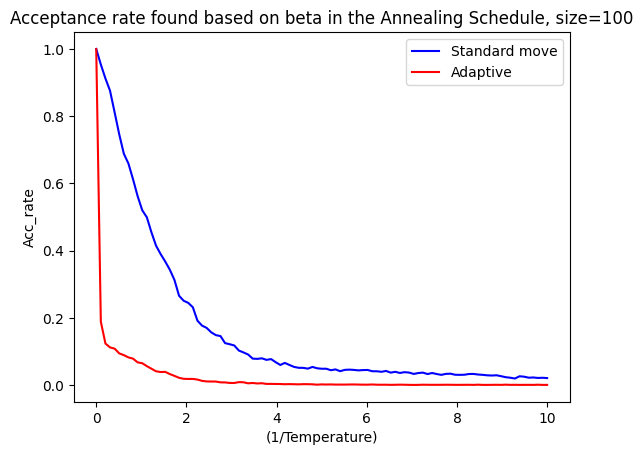

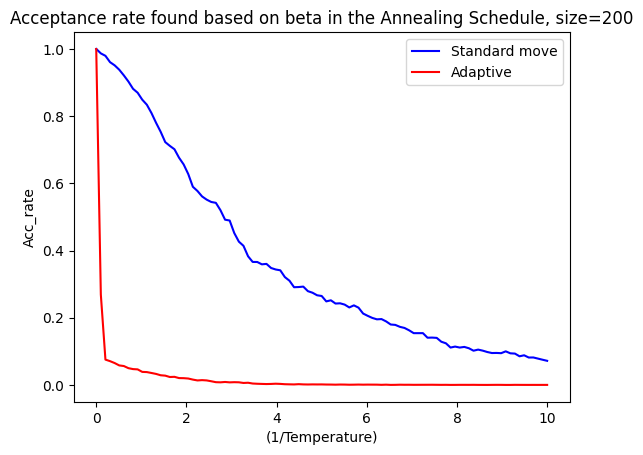

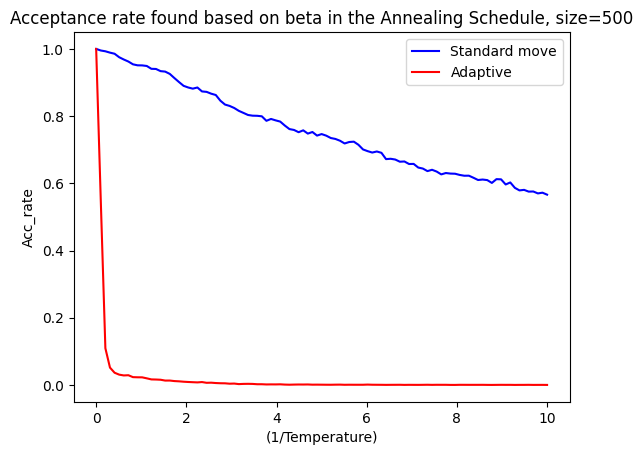

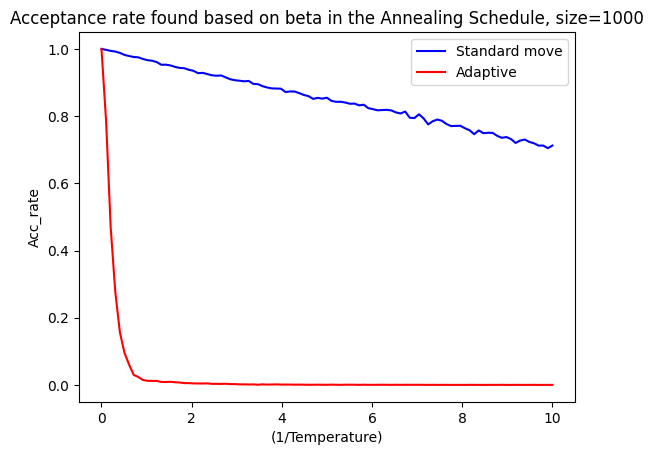

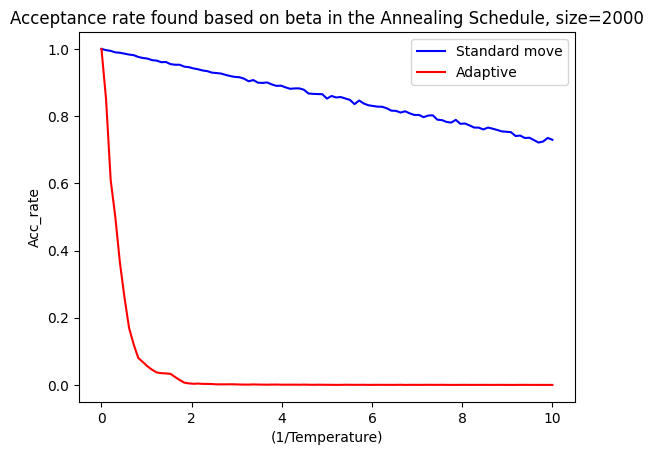

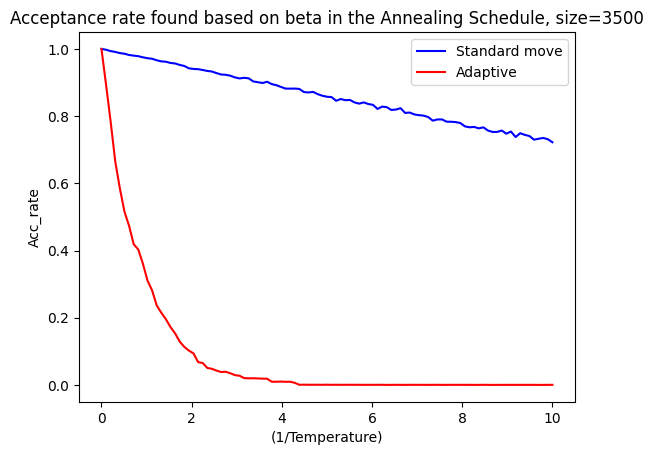

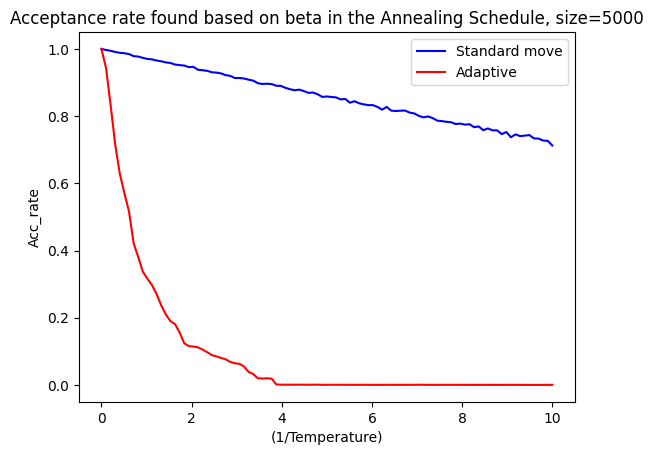

In [ ]:
def plot_task5(results_task5):
    acc_rate_by_n_std, acc_rate_by_n_adapt, beta_list, best_c_distribution_by_n_std, best_c_distribution_by_n_adapt = results_task5
    for i in range(len(n_schedule)):
        plt.plot(beta_list, acc_rate_by_n_std[i], '-', c = 'blue', label = 'Standard move')
        plt.plot(beta_list, acc_rate_by_n_adapt[i], '-', c = 'red', label = 'Adaptive')
        plt.xlabel('(1/Temperature)')
        plt.ylabel('Acc_rate')
        plt.title('Acceptance rate found based on beta in the Annealing Schedule, size={}'.format(n_schedule[i]))
        plt.legend()
        plt.show()
        
plot_task5(results_task5)
    

As expected, lower values of the acceptance rate correspond to lower values of the temperature, on average. 
Although it seems that the acceptance rate gracefully decreases while increasing beta, what truly happens is slightly different: a different perspective emerges by looking at the graphs representing the acceptance rates based on beta for individual cases.

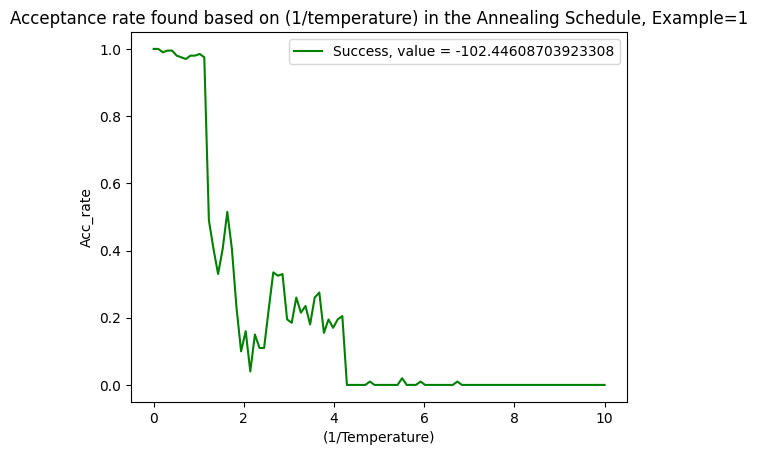

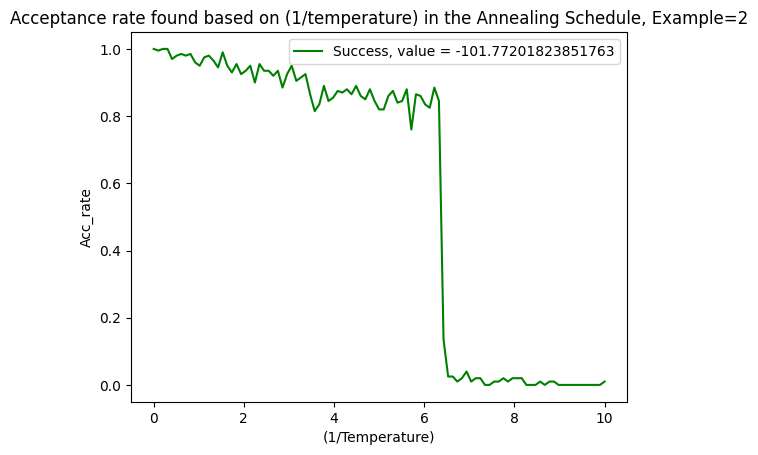

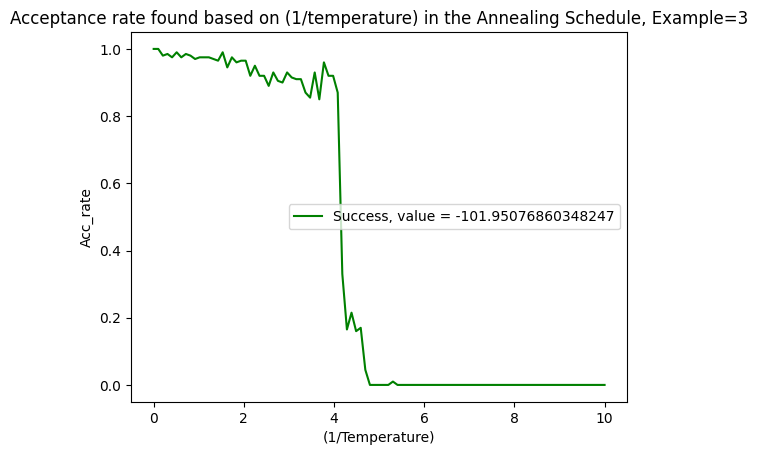

In [ ]:
def acc_rate_analysis(n = 200, ID = '3224274'):
    for k in range(3):
        t_final, best_c, min_seq, success, acc_rate_seq, beta_list = simann(n, ID, standard = True)
        if success:
            plt.plot(beta_list, acc_rate_seq, '-', c = 'green', label = 'Success, value = {}'.format(best_c))
        else:
            plt.plot(beta_list, acc_rate_seq, '-', c = 'red', label = 'Unsuccess, value = {}'.format(best_c))
        plt.xlabel('(1/Temperature)')
        plt.ylabel('Acc_rate')
        plt.title('Acceptance rate found based on (1/temperature) in the Annealing Schedule, Example={}'.format(k+1))
        plt.legend()
        plt.show()

        

acc_rate_analysis()

It now becomes clear what is truly happening at each trial of the optimization: the acceptance rate exhibits a deep fall whenever our algorithm is able to find a new configuration with a significantly lower cost.
Since our ‘accept’ is highly depending on the delta cost, once we accept the new best cost (which will be significanly lower that the previous one),  we will observe a drastic decrease in the acceptance rate. This is because the algorithm is performing an MCMC ‘walk’ in a region with an extremely high variance of costs ( the border of two regions ), many more proposals will be rejected with respect to the regular areas of the landscape, as highly positive delta costs will be found. 
Following this drastic drop, the acceptance rate recorded at the successive values of beta will be lower for two main factors:
• the regular ‘Beta effect’: increasing the value of beta, the ‘accept’ function will naturally reject more proposals (this happens in every case);
• a possible increase in the variance of the delta cost in the ‘lower cost’ region (the two (sub)optimal regions), with respect to the regular cost region (around 0).

In particular, running the experiment multiple times, I becomes noticeable that this behavior is shown in 2 different cases: • the optimal range is found (around -100) 
• a suboptimal range is found (around -50).

(100,)


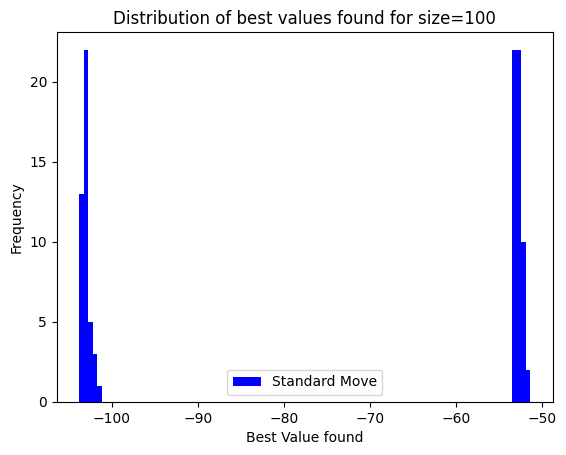

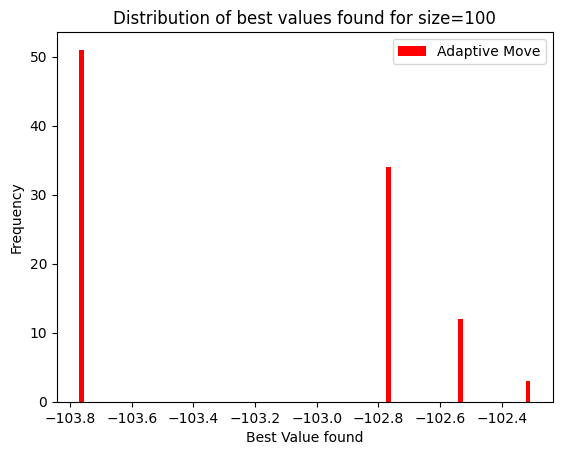

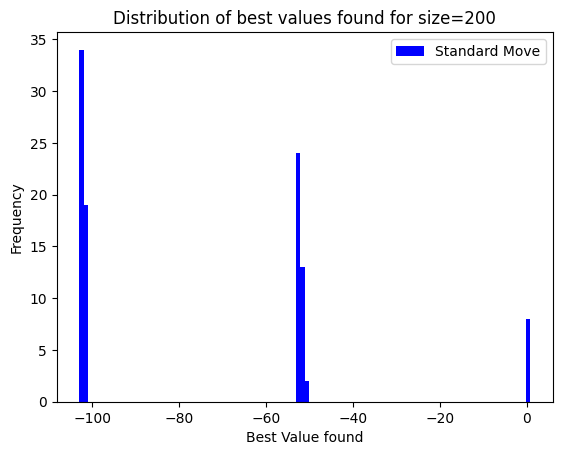

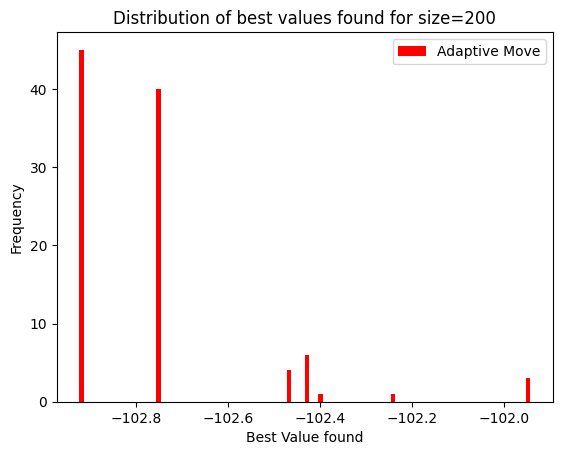

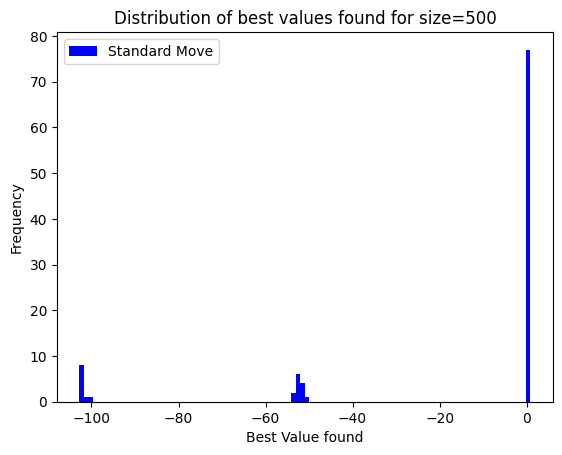

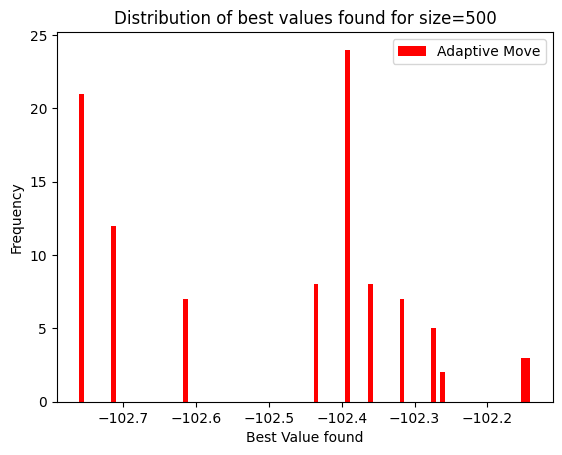

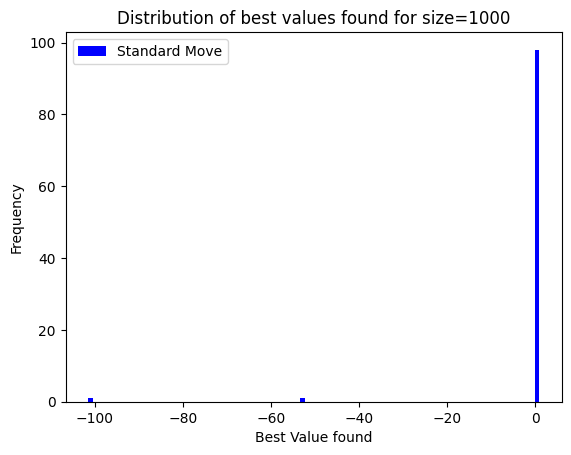

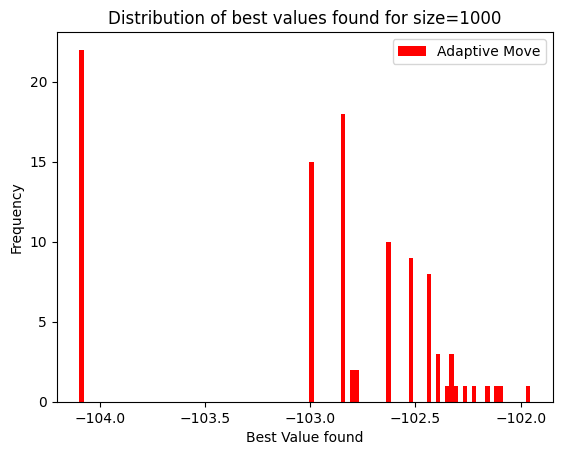

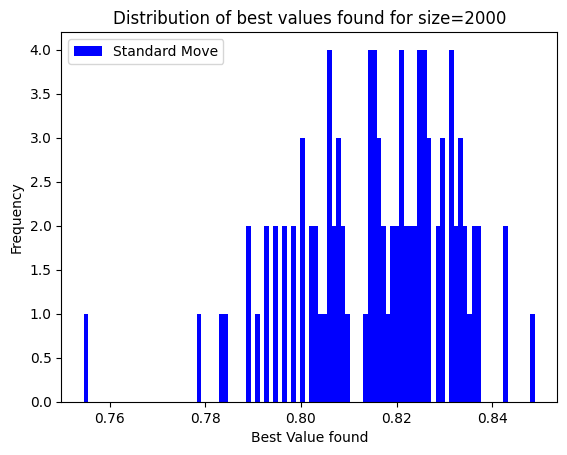

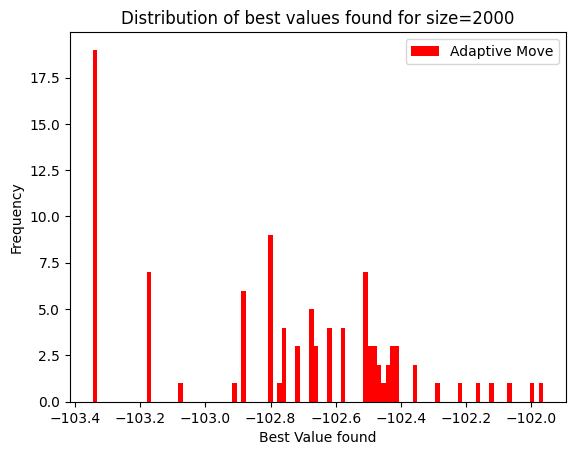

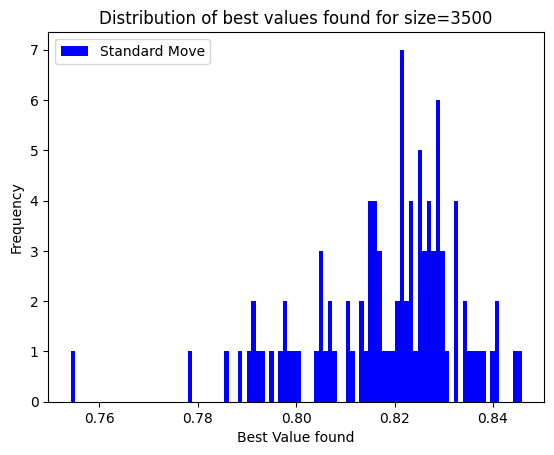

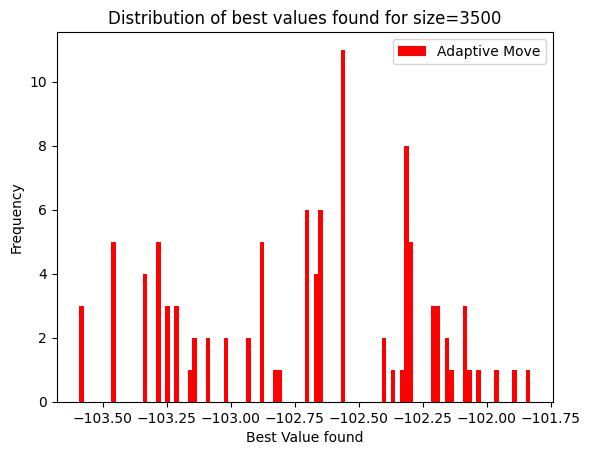

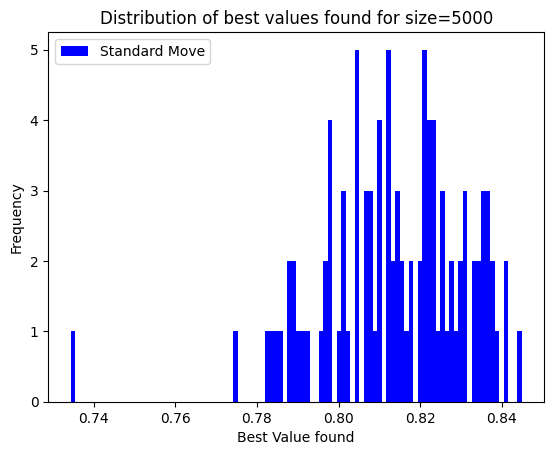

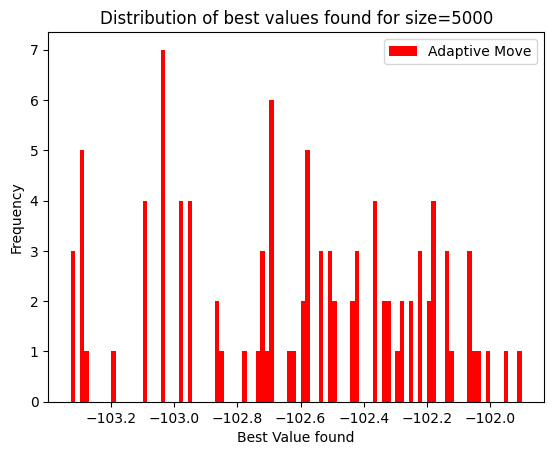

In [ ]:

def plot_task5_distribution(results_task5):
    acc_rate_by_n_std, acc_rate_by_n_adapt, beta_list, best_c_distribution_by_n_std, best_c_distribution_by_n_adapt = results_task5
    print(best_c_distribution_by_n_adapt[0].shape)
    for i in range(len(n_schedule)):
        plt.hist(best_c_distribution_by_n_std[i], bins = 100, color = 'blue', label = 'Standard Move')
        plt.xlabel('Best Value found')
        plt.ylabel('Frequency')
        plt.title('Distribution of best values found for size={}'.format(n_schedule[i]))
        plt.legend()
        plt.show()
        plt.hist(best_c_distribution_by_n_adapt[i], bins = 100, color = 'red', label = 'Adaptive Move')
        plt.xlabel('Best Value found')
        plt.ylabel('Frequency')
        plt.title('Distribution of best values found for size={}'.format(n_schedule[i]))
        plt.legend()
        plt.show()
plot_task5_distribution(results_task5)

OBSERVATION: The distribution of the Best Values found by the ‘Simann Function’ (100 trials) follows a trimodal distribution, which is coherent with the three examples above.
Therefore, we vertical fall in the 
In particular, as discussed earlier, our algorithm will struggle to find a (sub)obptimal range for problems of greater sizes, indicating that the acceptance rate will smoothly decrease without drastic falls (simply due to the increasing value beta which will progressively reduce the probability of accepting a move). On the other hand, if the optimization is able to find a (sub)optimal solution, the acceptance rate will have the ‘falling’ behavior described above.
All the gathered information suggests a specific landscape for our problem, with several peculiarities.
• The trimodal distribution suggests 3 different outcomes for our optimization: each exhibiting a considerable probability of happening for smaller instances of the problem. However, increasing the size of the landscape, the Best Value is progressively more probably found around 0, indicating that the three ‘areas’ of the solution space don’t always increase proportionally to the size of the problem.
• The drastic drop in the acceptance rate in case of (sub)successful attempts suggests that, given our standard move, it is difficult to keep exploring other portions of the solution space once our algorithm finds a (sub)optimal area (this effect in highlighted even more for greater sizes of the problem, in which it is more probable to find a (sub)optimal region later in the annealing process, resulting in a (nearly) zero probability of escaping due to the high value of beta).

TASK 6: Plotting the optimization for a fixed value of n, the aforehand described properties become more intuitive. 
The (sub) optimal regions don’t increase their total area proportionally to the problem, as expected. This explains why the convergence success rate decreases as the size of the problem increases. 
Moreover, given our Standard Move, the proportion of the area of the solution space our algorithm is able to cover gets smaller and smaller. 
These observations are coherent with the struggles found to effectively optimize our problem for greater instances of the data. 
In addition, the path towards the minimum is not smooth, the (sub) optimal regions represent a vertical fall with respect to the ‘yellow’ area. 
These properties not only explain the drastic drop in the acceptance rate once we find a minimum, but also the subsequent lower acceptance rates found after the drop: if the delta cost was similar between the (sub)optimal regions and the ‘yellow’ ones, we would observe the acceptance rate to get back to the its regular trend (slightly downwards sloping) once the algorithm gets over the ‘borders’ of the regions.
However, this doesn’t happen, indicating that the variance of the delta cost il greater in the (sub)optimal regions.
 
A suggested approach would be to increase the number of MCMC (or Annealing) steps to give our function more opportunities to further explore the solution space. Despite being theoretically correct, this solution would be too demanding from a computational perspective (we might as well check every point in the grid performing O(n^2) checks).
An alternative idea would consist in choosing lower values of beta, increasing the overall acceptance rate, and resulting in a greater covered area of the solution space. This approach will show too high acceptance rates even at the end of the optimization, basically performing a random walk on the landscape. 

Size of the problem: 100


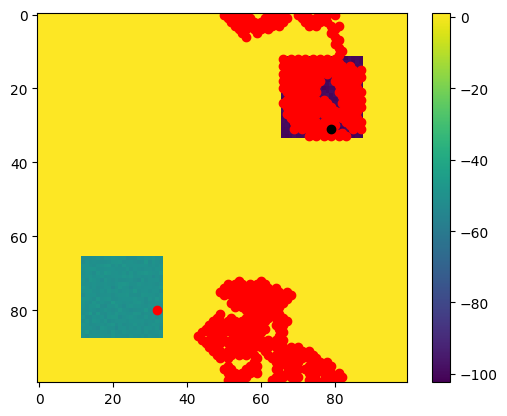

Size of the problem: 200


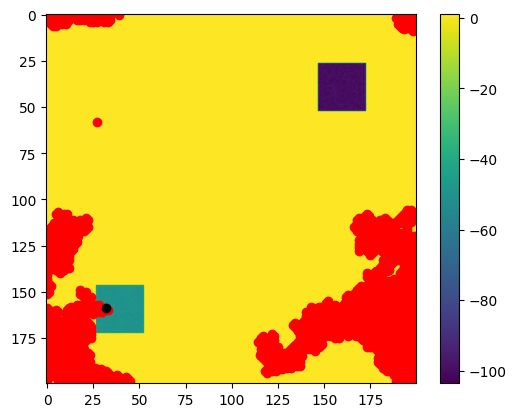

Size of the problem: 500


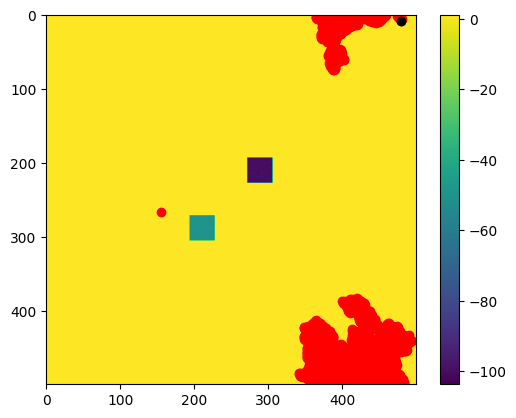

Size of the problem: 1000


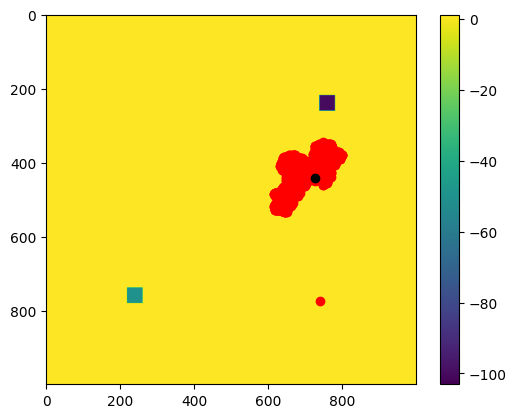

Size of the problem: 2000


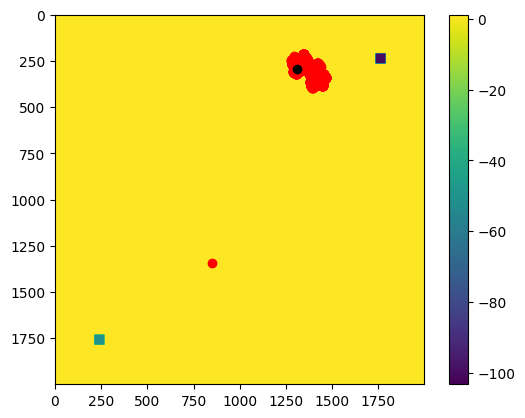

Size of the problem: 3500


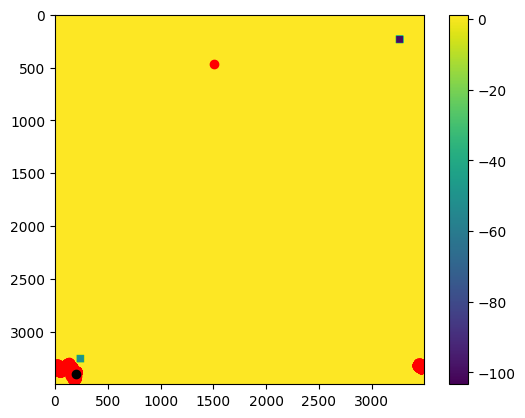

Size of the problem: 5000


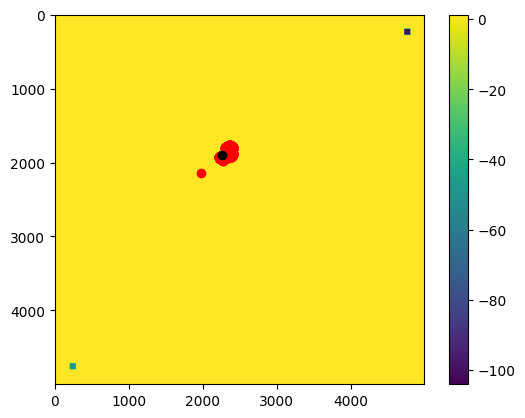

In [ ]:
n_schedule1 = [100, 200, 500, 1000, 2000, 3500, 5000]

def plot_landscape(n_schedule1, ID = '3224274'):
    for n in n_schedule1:
        print('Size of the problem: {}'.format(n))
        simann(n, ID, standard = True, plotting = True)

plot_landscape(n_schedule1)
        

TASK 7: Having considered all the information above, we can conclude our Simulated Annealing algorithm could be improved in many areas, in order to adapt to the specific problem, we are trying to tackle.
Running our algorithm for greater sizes of the problem we encountered some major problems: 
• the limited portion of the solution space we managed to cover using our Standard Move of 1 step
• the high correlation of our Best Value found to the initial point (initial points closer to the (sub)optimal regions result in higher probability of finding a (sub)optimal region)
• the higher variance in the delta costs in the (sub)optimal regions (we need to find a way to escape even close local minima if we intend to find the global minimum)

In order to solve those issues there can be adopted different strategies:
• setting the step of the algorithm to be a function of the size of the problem (ensuring that all necessary Simulated Annealing requirements are met)
• initializing the algorithm multiple times in order to further explore the solution space
• given the prior knowledge we have on the algorithm, adopted a naïve greedy approach consisting in choosing random points on the grid and returning the best one (although it may seem silly, it could be a good trade-off between computational complexity and accuracy in this case). 

I proceeded to implement the 2 alternative approaches: 
• 'simann_reinit': reinitializes the problem for a give number of times (repeats initialized at 10)
• 'naive greedy' which basically picks random points in the grid and proceeds as a normal greedy algorithm

In [ ]:
# create a simann function that re-initializes the problem 'repeats' times

def simann_reinit(n, ID, data = None, repeats=10, beta0=0.0001, beta1=10, anneal_steps=100, mcmc_steps=200, seed=None):

    t_initial = time.time()
    success = False


    if seed is not None:
        np.random.seed(seed)

    if data is None:
        data = generate_data(n, ID)

    best_c = np.inf
    betas = np.zeros(anneal_steps)
    betas[:-1] = np.linspace(beta0, beta1, anneal_steps-1)
    betas[-1] = np.inf
    
    probl = Probl(data)

    # for 'repeats' time
    for i in range(repeats):
        probl.init_config()
        cx = probl.cost()
        
        for beta in betas:

            for t in range(mcmc_steps):
                move = probl.propose_move_standard()
                delta_c = probl.compute_delta_cost(move)
                
                if accept(delta_c, beta):
                    probl.accept_move(move)
                    cx += delta_c
                    # coord = probl.x0, probl.y0
                    # print(f"Coordinates explored = {coord}")
                    
                    if best_c >= cx: 
                        best_c = cx
            
            if not success:
                if np.abs(best_c- np.min(data)) < 3:
                    t_final = time.time() - t_initial
                    success = True

    if not success:
        t_final = time.time() - t_initial
            

        
    # print(f"Best Cost = {best_c}")
    return best_c, t_final

(-102.61161373116828, 0.00824594497680664)

In [ ]:
def naive_greedy(n, ID, data = None, iterations = 1000):
    t0 = time.time()

    success = False
    if data is None:
        data = generate_data(n, ID)
    probl = Probl(data)
    best_cost = probl.cost()
    for i in range(iterations):
        probl.i = np.random.randint(0,n-1)
        probl.j = np.random.randint(0,n-1)
        new_cost = probl.cost()
        if (new_cost - best_cost) < 0:
            best_cost = new_cost

        if not success:
            if np.abs(best_cost- np.min(data)) < 3:
                t_final = time.time() - t0
                success = True
    if not success:
        t_final = time.time() - t0

    return best_cost, t_final
        

I ran some experiments to compare the 4 algorithms

In [ ]:
n_schedule = [100, 200, 500, 1000, 2000, 3500, 5000]
def comparison_models(n_schedule, ID = '3224274', trials = 10):
    
    t_opt_std_by_n = np.zeros((len(n_schedule)))
    t_opt_adapt_by_n = np.zeros((len(n_schedule)))
    t_opt_reinit_by_n = np.zeros((len(n_schedule)))
    t_opt_greedy_by_n  = np.zeros((len(n_schedule)))

    v_opt_std_by_n = np.zeros((len(n_schedule)))
    v_opt_adapt_by_n = np.zeros((len(n_schedule)))
    v_opt_reinit_by_n = np.zeros((len(n_schedule)))
    v_opt_greedy_by_n  = np.zeros((len(n_schedule)))



    for i, n in enumerate(n_schedule):

        data = generate_data(n, ID)

        #record avg times
        t_opt_std = np.zeros(trials)
        t_opt_adapt = np.zeros(trials)
        t_opt_reinit = np.zeros(trials)
        t_opt_greedy = np.zeros(trials)

        #record avg values
        v_opt_std = np.zeros(trials)
        v_opt_adapt = np.zeros(trials)
        v_opt_reinit = np.zeros(trials)
        v_opt_greedy = np.zeros(trials)


        
        for t in range(trials):
            
            # basic standar move, we only need convergence time and value
            t_opt_std[t], v_opt_std[t], matrix_values_std, converged_std, matrix_accept_rate_std, beta_list = simann(n, ID, data, standard = True, convergence=True)

            # basic adaptive move, we only need convergence time and value
            t_opt_adapt[t], v_opt_adapt[t], matrix_values_adapt, converged_adapt, matrix_accept_rate_adapt, beta_list = simann(n, ID, data, adaptive = True, convergence=True)
            
            # reinitialized annealing procedure, 10 reinitializations
            v_opt_reinit[t], t_opt_reinit[t] = simann_reinit(n, ID, data)
            
            # super naive greedy, 1000 iterations
            v_opt_greedy[t], t_opt_greedy[t] = naive_greedy(n, ID, data)


        #store the average values in the array composed by 7 dimensions (1 for each n in n_schedule)
        t_opt_std_by_n[i] = np.mean(t_opt_std)
        t_opt_adapt_by_n[i] =  np.mean(t_opt_adapt)
        t_opt_reinit_by_n[i] =  np.mean(t_opt_reinit)
        t_opt_greedy_by_n[i]  = np.mean(t_opt_greedy)

        # store the mean values of 10 trials
        v_opt_std_by_n[i ] = np.mean(v_opt_std)
        v_opt_adapt_by_n[i] = np.mean(v_opt_adapt)
        v_opt_reinit_by_n[i] = np.mean(v_opt_reinit)
        v_opt_greedy_by_n[i] = np.mean(v_opt_greedy)

    #separatly return the results
    results_std1 = t_opt_std_by_n, v_opt_std_by_n 
    results_adapt1 = t_opt_adapt_by_n, v_opt_adapt_by_n
    results_reinit1 = t_opt_reinit_by_n, v_opt_reinit_by_n
    results_greedy1 = t_opt_greedy_by_n , v_opt_greedy_by_n

    return results_std1, results_adapt1, results_reinit1, results_greedy1

results_std1, results_adapt1, results_reinit1, results_greedy1 = comparison_models(n_schedule)



100
200
500
1000
2000
3500
5000


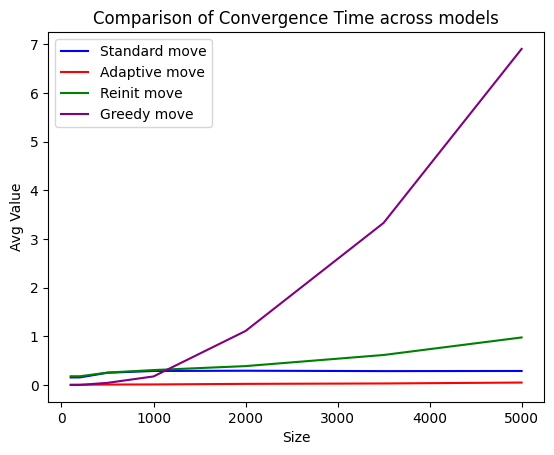

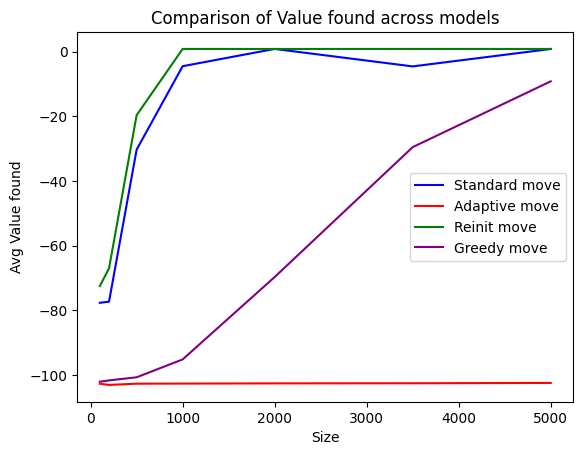

In [ ]:
def plot_comparison_models(results_std1, results_adapt1, results_reinit1, results_greedy1):
    
        plt.plot(n_schedule, results_std1[0], '-', c = 'blue', label = 'Standard move')
        plt.plot(n_schedule, results_adapt1[0], '-', c = 'red', label = 'Adaptive move')
        plt.plot(n_schedule, results_reinit1[0], '-', c = 'green', label = 'Reinit move')
        plt.plot(n_schedule, results_greedy1[0], '-', c = 'purple', label = 'Greedy move')
        plt.xlabel('Size')
        plt.ylabel('Avg Value')
        plt.title('Comparison of Convergence Time across models')
        plt.legend()
        plt.show()

        plt.plot(n_schedule, results_std1[1], '-', c = 'blue', label = 'Standard move')
        plt.plot(n_schedule, results_adapt1[1], '-', c = 'red', label = 'Adaptive move')
        plt.plot(n_schedule, results_reinit1[1], '-', c = 'green', label = 'Reinit move')
        plt.plot(n_schedule, results_greedy1[1], '-', c = 'purple', label = 'Greedy move')
        plt.xlabel('Size')
        plt.ylabel('Avg Value found')
        plt.title('Comparison of Value found across models')
        plt.legend()
        plt.show()


        

plot_comparison_models(results_std1, results_adapt1, results_reinit1, results_greedy1)

Overall, the Adaptive Move method performs better both from an optimization success rate and from a convergence time perspective. 
Surprisingly, the Naïve greedy method outperforms both the Standard and Reinitialization Methods in finding the minimum value, on average. 
On the other hand, this additional precision comes with a price, the algorithm will need to check more points, on average, to find an optimal range, resulting in an higher convergence time. 
In conclusion, despite its drawbacks, the simulated annealing problem, combined with an appropriate step choice (adaptive move), will result in the best trade off between precision and convergence time. 